# Introduction to Data Science – Lecture 13 – APIs
*COMP 5360 / MATH 4100, University of Utah, http://datasciencecourse.net/*

In this lecture we will explore how we can extract data from web-APIs. The first part of this tutorial is based on [this blog](https://www.dataquest.io/blog/python-api-tutorial/).

API stands for Application Programming Interface. It is supposed to be a **well defined interface** for consuming data (in contrast to web-scraping), or, more generally, for the **interaction with a remote program** on a server. APIs aren't only generated so that you can read data; they're often designed so that you could write custom software to interact with the API. You could, for example, write your own twitter client! 

APIs are usually well documented, as the organization that provides APIs wants you to use them. 

Here are a couple of examples of sites that have documented APIs:

 * [StackExchange](https://api.stackexchange.com/docs)  
 * [Twitter](https://dev.twitter.com/rest/public)
 * [Facebook](https://developers.facebook.com/docs/graph-api)
 * [KEGG](http://www.genome.jp/kegg/rest/keggapi.html) 
 * [Google Maps](https://developers.google.com/maps/) 
 * and many many more. 
 
Most APIs require some form of authentication and have rules on what you're allowed to do and what not. Follow those rules, or you will be blocked faster than you can say `GET`. 
 
Working with an API is a lot like working with a website, but instead of a human in front of the screen, it's computers talking to each other. 

We'll be using the dominant form of APIs on the web: REST (REpresentational State Transfer). REST APIs use an [URI](https://en.wikipedia.org/wiki/Uniform_Resource_Identifier) (a Uniform Resource Identifier; URLs are one specific form of URIs) to specify what you want to do with and API.

All API methods in REST are relative to a base URL. E.g., for twitter this would be
```
https://api.twitter.com/1.1/
```

A query would look like this: 

```
https://api.twitter.com/1.1/search/tweets.json?q=%40twitterapi
```


REST APIs can return data in different forms. The most common ones are JSON and XML, and of those two, JSON is now dominant. 

JSON stands for JavaScript Object Notation, and is a pretty convenient format, as we'll see. 
 

Let's start with a very simple example, retrieving the current position of the ISS. We will be using the [requests library](http://www.python-requests.org/en/latest/), which will handle our communication with the server.

In [1]:
import requests 
# Make a get request to get the latest position of the international space station from the opennotify api.
response = requests.get("http://api.open-notify.org/iss-now.json")

response

<Response [200]>

That looks good, we've received a response with the message "200". What does the 200 mean? It's a status code - you've probably seen the "Error 404" on the internet. 

Here are a couple of codes:

 * **200** – everything went okay, and the result has been returned (if any)
 * **301** – the server is redirecting you to a different endpoint. This can happen when a company switches domain names, or an endpoint name is changed.
 * **401** – the server thinks you’re not authenticated. This happens when you don’t send the right credentials to access an API (we’ll talk about authentication later).
 * **400** – the server thinks you made a bad request. This can happen when you don’t send along the right data, among other things.
 * **403** – the resource you’re trying to access is forbidden – you don’t have the right permissions to see it.
 * **404** – the resource you tried to access wasn’t found on the server.

Let's try to get a response with a wrong URL:

In [2]:
response_failed = requests.get("http://api.open-notify.org/iss")

response_failed

<Response [400]>

We used the get methods to put in a GET request. There are four different types of requests: 

![Request types](requests.png)
[Source](https://en.wikipedia.org/wiki/Representational_state_transfer)

Let's look at the payload of our previous, successful response:

In [3]:
response.content

b'{"timestamp": 1614709629, "message": "success", "iss_position": {"longitude": "101.8463", "latitude": "32.5211"}}'

We can already see that this is JSON (though it is stored a `bytes` object), but we can check formally:

In [4]:
response.headers['content-type']

'application/json'

We can decode this byte object, then the JSON will be readable. 

In [5]:
response_j = response.content.decode("utf-8")
print(response_j)

{"timestamp": 1614709629, "message": "success", "iss_position": {"longitude": "101.8463", "latitude": "32.5211"}}


Let's take a look at the JSON with nice formatting here:

```JSON
{
  "timestamp": 1475240215,
  "message": "success", 
  "iss_position": {
    "latitude": -30.005751854107206, 
    "longitude": -104.20085371352678
  } 
}
```

This looks a lot like a dictionary (or objects, for that matter)! We have key-value pairs. 

We can use the [json library](https://docs.python.org/3/library/json.html) to convert JSON into objects:

In [6]:
import json
response_d = json.loads(response_j)
print(type(response_d))
print(response_d)
response_d["iss_position"]

<class 'dict'>
{'timestamp': 1614709629, 'message': 'success', 'iss_position': {'longitude': '101.8463', 'latitude': '32.5211'}}


{'longitude': '101.8463', 'latitude': '32.5211'}

Or, not surprisingly, pandas can also load a json object:

In [7]:
import pandas as pd 

df = pd.read_json(response_j)
df

,timestamp,message,iss_position
latitude,2021-03-02 18:27:09,success,32.5211
longitude,2021-03-02 18:27:09,success,101.8463


This isn't quite what we want - we probably want one row per timestamp and longitude and latitude as columns:

In [8]:
def flatten(response_d):
    response_flat = {}
    response_flat["latitude"] = response_d["iss_position"]["latitude"]
    response_flat["longitude"] = response_d["iss_position"]["longitude"]
    response_flat["timestamp"] = response_d["timestamp"]
    return response_flat
flatten(response_d)

{'latitude': '32.5211', 'longitude': '101.8463', 'timestamp': 1614709629}

That looks better. Let's get a couple of positions of the ISS over time and save it as an array:

In [9]:
import time

def pull_position():
    """Retreives the position of the ISS and returns it as a flat dictionary"""
    response = requests.get("http://api.open-notify.org/iss-now.json")
    response_j = response.content.decode("utf-8")
    response_d = json.loads(response_j)
    flat_response = flatten(response_d)
    return flat_response    

iss_position = []
    
# calls pull_position 10 times with 3 seconds break
for i in range(10):
    flat_response = pull_position()
    iss_position.append(flat_response)
    print(flat_response)
    time.sleep(3)
    
len(iss_position)

{'latitude': '32.5649', 'longitude': '101.8987', 'timestamp': 1614709630}
{'latitude': '32.6964', 'longitude': '102.0563', 'timestamp': 1614709633}
{'latitude': '32.8276', 'longitude': '102.2143', 'timestamp': 1614709636}
{'latitude': '32.9586', 'longitude': '102.3728', 'timestamp': 1614709639}
{'latitude': '33.1111', 'longitude': '102.5584', 'timestamp': 1614709643}
{'latitude': '33.2415', 'longitude': '102.7181', 'timestamp': 1614709646}
{'latitude': '33.3717', 'longitude': '102.8782', 'timestamp': 1614709649}
{'latitude': '33.5017', 'longitude': '103.0389', 'timestamp': 1614709652}
{'latitude': '33.6315', 'longitude': '103.2001', 'timestamp': 1614709655}
{'latitude': '33.7610', 'longitude': '103.3618', 'timestamp': 1614709658}


10

Now we can convert this into a nice dataframe:

In [10]:
iss_position_df = pd.DataFrame(iss_position)
iss_position_df['timestamp']  = pd.to_datetime(iss_position_df['timestamp'], unit="s")

iss_position_df = iss_position_df.set_index(pd.DatetimeIndex(iss_position_df['timestamp']))
iss_position_df["latitude"] = iss_position_df["latitude"].map(float)
iss_position_df["longitude"] = iss_position_df["longitude"].map(float)
iss_position_df

,latitude,longitude,timestamp
timestamp,,,
2021-03-02 18:27:10,32.5649,101.8987,2021-03-02 18:27:10
2021-03-02 18:27:13,32.6964,102.0563,2021-03-02 18:27:13
2021-03-02 18:27:16,32.8276,102.2143,2021-03-02 18:27:16
2021-03-02 18:27:19,32.9586,102.3728,2021-03-02 18:27:19
2021-03-02 18:27:23,33.1111,102.5584,2021-03-02 18:27:23
2021-03-02 18:27:26,33.2415,102.7181,2021-03-02 18:27:26
2021-03-02 18:27:29,33.3717,102.8782,2021-03-02 18:27:29
2021-03-02 18:27:32,33.5017,103.0389,2021-03-02 18:27:32
2021-03-02 18:27:35,33.6315,103.2001,2021-03-02 18:27:35


Let's see how the ISS moves

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

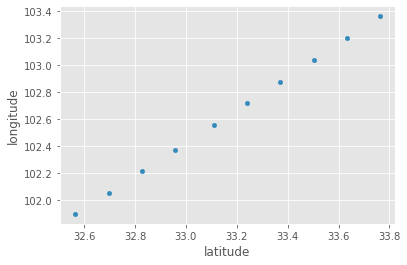

In [11]:
import matplotlib.pyplot as plt
# This next line tells jupyter to render the images inline
%matplotlib inline
plt.style.use('ggplot')
iss_position_df.plot(kind="scatter", x="latitude", y="longitude")

### Querying with Parameters

Requests can be parametrized. You can search for tweets of a specific user, for example, or [retrieve the time the ISS is over SLC](http://open-notify.org/Open-Notify-API/ISS-Pass-Times/)!

The way to query with a get request for the ISS is this:

`http://api.open-notify.org/iss-pass.json?lat=40.758701&lon=-111.876183`

We, of course, could generate that URL ourselves, but the requests library is helpful here. Since JSON is similar to dictionaries, the requests library takes dictionaries for parameters.

In [12]:
url = "http://api.open-notify.org/iss-pass.json"
coordinates = {"lat": 40.758701, "lon": -111.876183, "n":5}

r = requests.get(url, params=coordinates)
data = r.json()
data

{'message': 'success',
 'request': {'altitude': 100,
  'datetime': 1614709232,
  'latitude': 40.758701,
  'longitude': -111.876183,
  'passes': 5},
 'response': [{'duration': 617, 'risetime': 1614759566},
  {'duration': 641, 'risetime': 1614765357},
  {'duration': 572, 'risetime': 1614771243},
  {'duration': 578, 'risetime': 1614777112},
  {'duration': 646, 'risetime': 1614782925}]}

In [13]:
timestamp = data["response"][0]["risetime"]
pd.to_datetime(timestamp,  unit="s")

Timestamp('2021-03-03 08:19:26')

So, the ISS will be above SLC tomorrow morning!

## Libraries and Authentication

While we now have the skills to directly talk to an API, it's sometimes a little tedious. Popular APIs often have existing Python libraries that wrap around them. [Here](https://github.com/realpython/list-of-python-api-wrappers) is a long list of wrappers! 

Now we'll explore the Twitter API using the [twython library](https://github.com/ryanmcgrath/twython). Check out the [documentation](https://twython.readthedocs.io/en/latest/).

Unfortunately, most professional APIs will require you to authenticate and will limit you in what you can do – mostly they limit how much data you can retreive at a certain time. To run the following code, you'll have to put in your own credentials (sorry – I can't share mine). 

Install twython:
`pip install twython`

* Go to https://apps.twitter.com/ and create a new app
* Save your consumer key and consumer secret in a file `credentials.py` in the format:
```python
CONSUMER_KEY = "KEY"
CONSUMER_SECRET = "KEY"
```

But before we get started, let's check out what [a tweet looks like](https://dev.twitter.com/overview/api/tweets):

```JSON
{'created_at': 'Mon Mar 01 19:58:00 +0000 2021',
  'id': 1366477842213707784,
  'id_str': '1366477842213707784',
  'text': 'This afternoon, I’ll be meeting virtually with Mexican President Andrés Manuel López Obrador. The U.S.-Mexico relat… https://t.co/4M2OgsL7uX',
  'truncated': True,
  'entities': {'hashtags': [],
   'symbols': [],
   'user_mentions': [],
   'urls': [{'url': 'https://t.co/4M2OgsL7uX',
     'expanded_url': 'https://twitter.com/i/web/status/1366477842213707784',
     'display_url': 'twitter.com/i/web/status/1…',
     'indices': [117, 140]}]},
  'source': '<a href="https://www.sprinklr.com" rel="nofollow">The White House</a>',
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'in_reply_to_screen_name': None,
  'user': {'id': 1349149096909668363,
   'id_str': '1349149096909668363',
   'name': 'President Biden',
   'screen_name': 'POTUS',
   'location': '',
   'description': '46th President of the United States, husband to @FLOTUS, proud dad & pop. Tweets may be archived: https://t.co/IURuMIrzxb',
   'url': 'https://t.co/IxLjEB2zlE',
   'entities': {'url': {'urls': [{'url': 'https://t.co/IxLjEB2zlE',
       'expanded_url': 'http://WhiteHouse.gov',
       'display_url': 'WhiteHouse.gov',
       'indices': [0, 23]}]},
    'description': {'urls': [{'url': 'https://t.co/IURuMIrzxb',
       'expanded_url': 'http://whitehouse.gov/privacy',
       'display_url': 'whitehouse.gov/privacy',
       'indices': [98, 121]}]}},
   'protected': False,
   'followers_count': 8329657,
   'friends_count': 12,
   'listed_count': 9248,
   'created_at': 'Wed Jan 13 00:37:08 +0000 2021',
   'favourites_count': 0,
   'utc_offset': None,
   'time_zone': None,
   'geo_enabled': False,
   'verified': True,
   'statuses_count': 238,
   'lang': None,
   'contributors_enabled': False,
   'is_translator': False,
   'is_translation_enabled': False,
   'profile_background_color': 'F5F8FA',
   'profile_background_image_url': None,
   'profile_background_image_url_https': None,
   'profile_background_tile': False,
   'profile_image_url': 'http://pbs.twimg.com/profile_images/1349837426626330628/CRMNXzQJ_normal.jpg',
   'profile_image_url_https': 'https://pbs.twimg.com/profile_images/1349837426626330628/CRMNXzQJ_normal.jpg',
   'profile_banner_url': 'https://pbs.twimg.com/profile_banners/1349149096909668363/1614313035',
   'profile_link_color': '1DA1F2',
   'profile_sidebar_border_color': 'C0DEED',
   'profile_sidebar_fill_color': 'DDEEF6',
   'profile_text_color': '333333',
   'profile_use_background_image': True,
   'has_extended_profile': True,
   'default_profile': True,
   'default_profile_image': False,
   'following': None,
   'follow_request_sent': None,
   'notifications': None,
   'translator_type': 'none'},
  'geo': None,
  'coordinates': None,
  'place': None,
  'contributors': None,
  'is_quote_status': False,
  'retweet_count': 2155,
  'favorite_count': 19136,
  'favorited': False,
  'retweeted': False,
  'lang': 'en'}
```


In [14]:
from twython import Twython
# credentials is a local file with your own credentials. It defines CONSUMER_KEY and CONSUMER_SECRET
# you will have to load your own credentials here.
from credentials_alex import * 
twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET)

Here, we have created the Twython library object and authenticated against our user.

Now let's search for a hashtag:

In [15]:
tag = "#covid19"
result = twitter.search(q=tag, tweet_mode="extended")
result

{'statuses': [{'created_at': 'Tue Mar 02 18:27:41 +0000 2021',
   'id': 1366817503616266244,
   'id_str': '1366817503616266244',
   'full_text': 'RT @GavinNewsom: NEW: CA has now administered over 9 million #COVID19 vaccines.\n\nOur test positivity rate has dropped to 2.3%.\n\nToday we re…',
   'truncated': False,
   'display_text_range': [0, 140],
   'entities': {'hashtags': [{'text': 'COVID19', 'indices': [61, 69]}],
    'symbols': [],
    'user_mentions': [{'screen_name': 'GavinNewsom',
      'name': 'Gavin Newsom',
      'id': 11347122,
      'id_str': '11347122',
      'indices': [3, 15]}],
    'urls': []},
   'metadata': {'iso_language_code': 'en', 'result_type': 'recent'},
   'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
   'in_reply_to_status_id': None,
   'in_reply_to_status_id_str': None,
   'in_reply_to_user_id': None,
   'in_reply_to_user_id_str': None,
   'in_reply_to_screen_name': None,
   'user': {'id': 197855235,
    'id

The result is an array of tweets, we can look at specific text:

In [16]:
result["statuses"][0]["full_text"]

'RT @GavinNewsom: NEW: CA has now administered over 9 million #COVID19 vaccines.\n\nOur test positivity rate has dropped to 2.3%.\n\nToday we re…'

Or print all the tweets:

In [17]:
for status in result["statuses"]:
    print(status["full_text"])
    print("----")

RT @GavinNewsom: NEW: CA has now administered over 9 million #COVID19 vaccines.

Our test positivity rate has dropped to 2.3%.

Today we re…
----
RT @Lichower: #LaTareaEsCuidarte 🧑‍💻📝

Vas a viajar en avión ✈️❓ Anota y toma en cuentas estas medidas sanitarias 📝 como parte de responsab…
----
RT @HoChiMinhF: AHORA || #Nicaragua 🇳🇮

Primeros pacientes son vacunados contra el #COVID19 

@MinsaNicaragua 
@DMatagalpa 

#UnidosEnVicto…
----
RT @TheTyee: To date, at least two-thirds of the 21,905 people who have died of #COVID19 in Canada lived in long-term care or assisted livi…
----
RT @LupitaJuarezH: ⚠️ Da positivo a segunda prueba de #Covid19 el secretario de la Defensa, Luis Cresencio Sandoval. #SEDENA. https://t.co/…
----
La nomina di Draghi al posto di Conte quindi è come il Twix al posto del Raider.. uguale al precedente ma co la confezione più fica.. #conferenzastampa #Draghi #Conte #Dpcm #COVID19 https://t.co/lmBuxA7ml1
----
RT @Figaro_Live: 🇺🇸États-unis: une forte augmentation des r

## Analysis of Twitter Popularity

Let's do a brief analysis of twitter popularity of two political figures: Joe Biden's official POTUS account and Alexandria Ocasio-Cortez. As you would expect, Biden's personal account has more twitter followers (29 million) than AOC (12.6 million), though the POTUS account has only 8 million followers. We're using the POTUS account, because Biden's account has mostly been used for retweeting POTUS ever since he took office. As an aside, Barack Obama has 130 million followers, and Justin Bieber has 114 million. 

We can search for tweets based on usernames:

In [18]:
result = twitter.search(q="@joebiden",  tweet_mode="extended")
for status in result["statuses"]:
    print(status["full_text"])
    print("----")

RT @WBrettWilson: Biden spokesperson rules out helping Canada, Mexico with vaccine supply before all Americans are inoculated - @CBCNews

N…
----
RT @pmigoya: Ayer quedó desnudo la burda farsa del presidentito @lopezobrador_  nunca existió los 120mil millones que dijo ser destinados p…
----
RT @ElAmaDeCasa1: Oiga @lopezobrador_ , le pregunto:
¿ Qué consiguió durante su encuentro virtual con @JoeBiden ?
¿ Vacunas? ¿ Empleo para…
----
@Charloar @Teregomezf @Amadoelquelolea @lopezobrador_ @JoeBiden Jajajajajajajaja@¿que cambia? El contesto del tweet; quedó como pendejo el@que lo puso, nada más. 🤣🤣🤣✍️
----
@martiriafelix @lopezobrador_ @JoeBiden Reverendo p3nd3j0 🤮
----
@elonmusk @AHouse_LA @JoeBiden @AOC @FBI @DhaniHarrison @SCE @KamalaHarris @bbvaedufin @userewind Integrity is using voice; defend innocent.
----
@Dafneconefe Pues que ayer ni con la lamida de suelas vergonzosa que le aplicó @lopezobrador_ a @JoeBiden lograron que donaran vacunas... 
ya no es “misión cumplida”, verdad @m_eb

This returns all tweets that are mentioning a username. 

We can also explicitly get the tweets of a person. Let's download Biden's last 50 tweets. [Here](https://dev.twitter.com/rest/reference/get/statuses/user_timeline) is the relevant API documentation, [here](https://github.com/ryanmcgrath/twython/blob/master/twython/endpoints.py) are the definitions for twython. 

Note that you get an error message if you try this with an account that is locked (like Trump's) or that doesn't exist.

In [19]:
#twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

# count is limited to the last 3200 tweets of a user, a max of 200 per request
biden_result = twitter.get_user_timeline(screen_name="potus", count=50)
biden_result

[{'created_at': 'Tue Mar 02 18:08:00 +0000 2021',
  'id': 1366812548088086532,
  'id_str': '1366812548088086532',
  'text': 'The fact is that $600 is not enough. The Senate needs to pass the American Rescue Plan and finish the job of delive… https://t.co/LqSBIeeH05',
  'truncated': True,
  'entities': {'hashtags': [],
   'symbols': [],
   'user_mentions': [],
   'urls': [{'url': 'https://t.co/LqSBIeeH05',
     'expanded_url': 'https://twitter.com/i/web/status/1366812548088086532',
     'display_url': 'twitter.com/i/web/status/1…',
     'indices': [117, 140]}]},
  'source': '<a href="https://www.sprinklr.com" rel="nofollow">The White House</a>',
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'in_reply_to_screen_name': None,
  'user': {'id': 1349149096909668363,
   'id_str': '1349149096909668363',
   'name': 'President Biden',
   'screen_name': 'POTUS',
   'location': '',
   'description': '46th Pr

Let's count the numbers for Biden's favorites and retweets.

In [20]:
biden_favorites = []
biden_retweets = []
biden_texts = []
for status in biden_result:
    print(status["text"])
    print(status["favorite_count"])
    print("----")
    biden_favorites.append(status["favorite_count"])
    biden_retweets.append(status["retweet_count"])
    biden_texts.append(status["text"])

The fact is that $600 is not enough. The Senate needs to pass the American Rescue Plan and finish the job of delive… https://t.co/LqSBIeeH05
13924
----
I had a great meeting with Mexican President Andrés Manuel López Obrador this afternoon. From migration to climate… https://t.co/gAX4hkV1JH
22931
----
Wash your hands.
Stay socially distanced.
Wear a mask.
Get vaccinated when it’s your turn.

Despite our progress, w… https://t.co/MHwHvgwpsp
104984
----
During Women's History Month, let us honor the accomplished and visionary women who have helped build our country.… https://t.co/zQPyVgaOqn
30109
----
This afternoon, I’ll be meeting virtually with Mexican President Andrés Manuel López Obrador. The U.S.-Mexico relat… https://t.co/4M2OgsL7uX
39149
----
No child in America should go hungry. The American Rescue Plan will extend and invest in critical food programs to… https://t.co/huI8Zfzre5
23370
----
On Saturday, the FDA issued an emergency use authorization for the Johnson &amp; Johnson C

Now let's do the same for Alexandria Ocasio-Cortez.

In [21]:
aoc_results = twitter.get_user_timeline(screen_name="aoc", count=50)
aoc_results

[{'created_at': 'Mon Mar 01 22:57:38 +0000 2021',
  'id': 1366523047872770053,
  'id_str': '1366523047872770053',
  'text': 'Congress needs to allocate enough funds so that internships can be paid. It currently does not. There’s some scant… https://t.co/C5YCaJbxXQ',
  'truncated': True,
  'entities': {'hashtags': [],
   'symbols': [],
   'user_mentions': [],
   'urls': [{'url': 'https://t.co/C5YCaJbxXQ',
     'expanded_url': 'https://twitter.com/i/web/status/1366523047872770053',
     'display_url': 'twitter.com/i/web/status/1…',
     'indices': [116, 139]}]},
  'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
  'in_reply_to_status_id': 1366520392152711173,
  'in_reply_to_status_id_str': '1366520392152711173',
  'in_reply_to_user_id': 138203134,
  'in_reply_to_user_id_str': '138203134',
  'in_reply_to_screen_name': 'AOC',
  'user': {'id': 138203134,
   'id_str': '138203134',
   'name': 'Alexandria Ocasio-Cortez',
   'screen_name': 'AOC',
 

In [22]:
aoc_favorites = []
aoc_retweets = []
aoc_texts = []
for status in aoc_results:
    print(status["text"])
    print(status["favorite_count"])
    print("----")
    aoc_favorites.append(status["favorite_count"])
    aoc_retweets.append(status["retweet_count"])
    aoc_texts.append(status["text"])

Congress needs to allocate enough funds so that internships can be paid. It currently does not. There’s some scant… https://t.co/C5YCaJbxXQ
19054
----
Pay your interns!

It’ll improve your operation and make it more diverse and just. You won’t be relying on privileg… https://t.co/lE6g56JCIT
75282
----
RT @meenaharris: Experience doesn’t pay the bills. https://t.co/HL4RqY7zQz
0
----
RT @PatrioticMills: .@AOC is right! We have two options in the continued #FightFor15 

1. Override the Parliamentarian's advice &amp; move forw…
0
----
RT @sahilkapur: .@SenWarren supports the calls from House progressives to evade the parliamentarian to raise the minimum wage. “This is a s…
0
----
RT @JoeNBC: How funny that Republicans in 2020 attacked Democrats as being radically out of step with Americans. And yet it’s not ⁦@AOC⁩ or…
0
----
RT @justicedems: “Any person who thinks that a $15 minimum wage is the ‘crazy socialist agenda’ is living in a dystopian capitalist nightma…
0
----
RT @JStein_WaPo: “P

And let's create DataFrames for both of them and explore their stats:

In [23]:
biden_stats = pd.DataFrame({
        "Biden Fav":biden_favorites,
        "Biden RT":biden_retweets,
        "Biden Text":biden_texts
    })

aoc_stats = pd.DataFrame({
      "AOC Fav":aoc_favorites,
      "AOC RT":aoc_retweets, 
      "AOC Text":aoc_texts
        })

In [24]:
biden_stats.head()

,Biden Fav,Biden RT,Biden Text
0,13924,2002,The fact is that $600 is not enough. The Senat...
1,22931,2629,I had a great meeting with Mexican President A...
2,104984,13047,Wash your hands.\nStay socially distanced.\nWe...
3,30109,4369,"During Women's History Month, let us honor the..."
4,39149,4104,"This afternoon, I’ll be meeting virtually with..."


In [25]:
biden_stats.describe()

,Biden Fav,Biden RT
count,50.000000,50.000000
mean,54526.120000,6739.740000
std,57611.274596,5924.591252
min,0.000000,1557.000000
25%,18152.250000,2884.750000
50%,29820.000000,4252.500000
75%,70393.750000,8819.000000
max,278502.000000,27232.000000


We will plot the tweet data; but we have to sort them first so that they make sense. 

In [26]:
biden_stats = biden_stats.sort_values("Biden Fav", ascending=False)
biden_stats = biden_stats.reset_index(drop=True)
biden_stats.head(30)

,Biden Fav,Biden RT,Biden Text
0,278502,21736,Not many people have Oval Office walk-in privi...
1,207132,27232,A Black man should be able to go for a jog wit...
2,193875,22181,Transgender rights are human rights — and the ...
3,169377,16246,"To heal, we must remember. https://t.co/LVfAnR..."
4,129635,16831,If there’s one message I want to cut through t...
5,126201,13091,"The more people that get vaccinated, the faste..."
6,104984,13047,Wash your hands.\nStay socially distanced.\nWe...
7,97065,13889,"500,000 lives lost to COVID-19. It’s an unfath..."
8,90223,11145,I am pleased that the House will vote next wee...
9,87047,8932,"The week before I took office, 6 million COVID..."


In [27]:
biden_stats.tail(10)

,Biden Fav,Biden RT,Biden Text
40,17264,2578,Small businesses are the backbone of our commu...
41,16811,3023,I know folks have a lot of questions about COV...
42,16711,2405,"This week, our Administration opened a new vac..."
43,14926,1770,"I’ve known Secretary Vilsack for years, and th..."
44,13924,2002,The fact is that $600 is not enough. The Senat...
45,12443,1757,Ambassador Linda Thomas-Greenfield is right: D...
46,12308,1889,I launched a whole-of-government initiative to...
47,10016,1557,"This afternoon, I’m holding a roundtable discu..."
48,0,4136,RT @WhiteHouse: To celebrate Black History Mon...
49,0,2265,"RT @WhiteHouse: Tune in as the President, Firs..."


In [28]:
aoc_stats = aoc_stats.sort_values("AOC Fav", ascending=False)
aoc_stats = aoc_stats.reset_index(drop=True)
aoc_stats.head(30)

,AOC Fav,AOC RT,AOC Text
0,386708,58300,"I don’t care what Cruz said at CPAC, but I do ..."
1,228892,28707,Preserving the filibuster is not worth letting...
2,222159,38448,"This is not okay, never has been okay, never w..."
3,200377,23134,One last update (I think!): We just hit $5 mil...
4,158507,15159,You could just vote “no” instead of trying to ...
5,132662,23138,Shout out to everyone who fought against commu...
6,112473,7747,"We’re gonna pass the #EqualityAct today, prote..."
7,110521,11017,Lindsey Boylan and Charlotte Bennett’s detaile...
8,100003,20452,Jeff Sessions was so openly racist that even R...
9,92282,9609,Please ask yourself: when was the last time yo...


In [29]:
combined = aoc_stats.copy()
combined["Biden Fav"] = biden_stats["Biden Fav"]
combined["Biden RT"] = biden_stats["Biden RT"]

<AxesSubplot:>

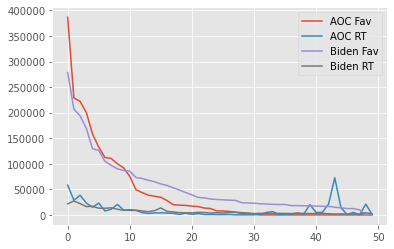

In [30]:
combined.plot()